# CAI4104 Final Project: First CNN Trial

In [31]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import utils

# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print(f'### NumPy version: {np.__version__}')
print(f'### SciPy version: {sp.__version__}')
print(f'### Scikit-learn version: {sklearn.__version__}')
print(f'### Tensorflow version: {tf.__version__}')
print('------------')


------------
### Python version: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
### NumPy version: 1.22.3
### SciPy version: 1.8.0
### Scikit-learn version: 0.24.2
### Tensorflow version: 2.7.0
------------


## Loading the data

In [32]:
# Relative path to .npy files
data_path = '../data/'
data = np.load(data_path + 'data.npz')

# Load numpy arrays
train_x = data['train_x']
train_t = data['train_t']

val_x = data['val_x']
val_t = data['val_t']

test_x = data['test_x']
test_t = data['test_t']

assert train_x.shape[0] == train_t.shape[0], "Training image quantity mismatches label quantity"
assert val_x.shape[0] == val_t.shape[0], "Validation image quantity mismatches label quantity"
assert test_x.shape[0] == test_t.shape[0], "Test image quantity mismatches label quantity"

# Data shapes
num_images = train_x.shape[0] + val_x.shape[0] + test_x.shape[0]
image_shape = train_x.shape[1:]

print(f'{num_images} images with shape {image_shape}')

35887 images with shape (48, 48, 1)


In [33]:
# Load augmented data
data_aug = np.load(data_path + 'data_aug.npz')
train_x_aug = data_aug['train_x']
train_t_aug = data_aug['train_t']

train_x_aug.shape, train_t_aug.shape

((122885, 48, 48, 1), (122885, 7))

In [34]:
# Append augmented data
train_x_all = np.concatenate((train_x, train_x_aug))
train_t_all = np.concatenate((train_t, train_t_aug))

train_x_all.shape, train_t_all.shape

((148005, 48, 48, 1), (148005, 7))

## Exploring the data

In [35]:
# Category names (implicitly stores labels as indices)
categories = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
category_numbers = dict(zip(categories, np.arange(0, len(categories))))
num_categories = len(categories)

In [36]:
def categorical_to_int(cat):
    return np.argmax(cat)

def display_sample(index: int):
    plt.title(f'Training image {index}: {categories[categorical_to_int(train_t_all[index])]}')
    plt.imshow(train_x_all[index], cmap='gray')

In [37]:
train_t_num = np.array([np.argmax(a) for a in train_t])
train_t_num

array([4, 3, 5, ..., 3, 0, 3])

(array([3471.,  377., 3559., 6330., 4346., 7037.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

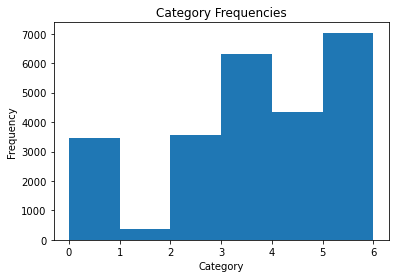

In [38]:
# Plot category frequencies
plt.title('Category Frequencies')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.hist(train_t_num, bins=np.arange(num_categories))


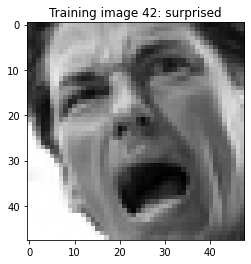

In [39]:
display_index = 42
display_sample(display_index)

## CNN Training

In [41]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall


model = keras.models.Sequential(name='CNN')

# Conv-pool repetitions
model.add(Conv2D(64, kernel_size=(4,4), input_shape=image_shape, padding='same', activation='relu', name='conv1'))
model.add(Conv2D(64, kernel_size=(4,4), input_shape=image_shape, padding='same', activation='relu', name='conv2'))

model.add(MaxPooling2D(2, name='maxpool1'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(96, kernel_size=(4,4), padding='same', activation='relu', name='conv3'))
model.add(keras.layers.Conv2D(96, kernel_size=(4,4), padding='same', activation='relu', name='conv4'))

model.add(MaxPooling2D(2, name='maxpool2'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(128, kernel_size=(4,4), padding='same', activation='relu', name='conv5'))
model.add(keras.layers.Conv2D(128, kernel_size=(4,4), padding='same', activation='relu', name='conv6'))
model.add(MaxPooling2D(2, name='maxpool3'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(192, kernel_size=(4,4), padding='same', activation='relu', name='conv7'))
model.add(keras.layers.Conv2D(192, kernel_size=(4,4), padding='same', activation='relu', name='conv8'))
model.add(MaxPooling2D(2, name='maxpool4'))
model.add(BatchNormalization())
'''model.add(keras.layers.Conv2D(256, kernel_size=(4,4), padding='same', activation='relu', name='conv9'))
model.add(keras.layers.Conv2D(256, kernel_size=(4,4), padding='same', activation='relu', name='conv10'))
model.add(MaxPooling2D(2, name='maxpool5'))
model.add(BatchNormalization())'''

# Flatten
model.add(Flatten(name='Flatten'))
# Fully connected funnel
'''model.add(Dense(256, activation='relu', name='fc0'))
model.add(Dropout(0.25, name='drop0'))'''
model.add(Dense(196, activation='relu', name='fc1'))
model.add(Dropout(0.25, name='drop1'))
model.add(Dense(128, activation='relu', name='fc2'))
model.add(Dropout(0.25, name='drop2'))
model.add(Dense(64, activation='relu', name='fc3'))
model.add(Dropout(0.25, name='drop3'))
model.add(Dense(32, activation='relu', name='fc4'))
model.add(Dropout(0.25, name='drop4'))
# Output
model.add(Dense(num_categories, activation='softmax', name='output'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

model.summary()    
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', Precision(), Recall()])

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 64)        1088      
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        65600     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 24, 24, 64)        0         
                                                                 
 batch_normalization_56 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 96)        98400     
                                                                 
 conv4 (Conv2D)              (None, 24, 24, 96)        147552    
                                                               

In [42]:
max_epochs = 20
batch_size = 512

early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/cnn.keras",monitor='val_loss', save_best_only=True, save_weights_only=False)
history = model.fit(train_x_all, train_t_all, validation_data=(val_x, val_t), epochs=max_epochs, batch_size=batch_size, 
                    shuffle=True, callbacks=[early_stop_cb, checkpoint_cb], verbose=1)

Epoch 1/20
290/290 [==============================] - 14s 41ms/step - loss: 1.7216 - accuracy: 0.2940 - precision_6: 0.6883 - recall_6: 0.0565 - val_loss: 1.8124 - val_accuracy: 0.2870 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/20
290/290 [==============================] - 11s 39ms/step - loss: 1.3824 - accuracy: 0.4632 - precision_6: 0.7815 - recall_6: 0.2281 - val_loss: 1.4672 - val_accuracy: 0.4379 - val_precision_6: 0.9489 - val_recall_6: 0.1035
Epoch 3/20
290/290 [==============================] - 11s 39ms/step - loss: 1.2128 - accuracy: 0.5452 - precision_6: 0.7851 - recall_6: 0.3185 - val_loss: 1.2080 - val_accuracy: 0.5397 - val_precision_6: 0.7625 - val_recall_6: 0.3327
Epoch 4/20
290/290 [==============================] - 11s 39ms/step - loss: 1.1103 - accuracy: 0.5937 - precision_6: 0.7873 - recall_6: 0.3860 - val_loss: 1.1299 - val_accuracy: 0.5826 - val_precision_6: 0.7810 - val_recall_6: 0.3795
Epoch 5/20
290/290 [==============================] - 11

In [43]:
np.save("../histories/my_hist", history.history)
model.save('../model/model_cache')

2024-04-26 19:23:42.775595: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/model_cache/assets


In [46]:
loss, acc, precision, recall = model.evaluate(test_x, test_t, verbose=1)
print(f'Test Accuracy: {acc}')

169/169 [==============================] - 1s 5ms/step - loss: 1.3873 - accuracy: 0.7561 - precision_6: 0.7708 - recall_6: 0.7431
Test Accuracy: 0.756129264831543


In [51]:
np.save("../predicted/test_t_cnn_pred", model.predict(test_x))

In [2]:
# Evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
model = keras.models.load_model('../model/model_cache')

# Predict labels for the test set
predicted_labels = model.predict(test_x)
predicted_labels = np.argmax(predicted_labels, axis=1)

true_labels = np.argmax(test_t, axis=1)

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

NameError: name 'keras' is not defined